<a href="https://colab.research.google.com/github/CianOSull/AutoML_With_SA_FYP_2021/blob/H2O/Copy_of_H2O_MainNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generic Notebook for running all the libraries

How this notebook works is that it contains the code
for loading and cleaning the dataset.

Then there is multiple branches created on the
Github that include the code for running each library.

E.g. MLBox branch has the code for running MLBox.

# CURRENT BRANCH: H2O

# Install Library

In [ ]:
# Insert any install comamnds in this cell
!apt-get install default-jre
!java -version
!pip install h2o

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.
openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


# Preprocessing Section

In [ ]:
# Import the necessary modules for cleaning
import math
import time 
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize 
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [ ]:
# Download the necessary parts for the NLTK module
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Create Model Section

**Documentation on manipulating data for h2o**

http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-munging.html

http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html#automl-interface

# Youtube tutorial
https://github.com/srivatsan88/YouTubeLI/blob/master/H2O_AutoML.ipynb

**BIG NOTE**

It seems because of how much H2O automates everything, it only takes in files. Thus a possible solution for running it on the tf idf values is to make a pandas dataframe using the numpy values, then convert it to a csv file and then feed it into the h2o.

There is also h2o.sklearn which allows h2o to work with sklearn and does allow it to work with numpy so maybe test that out.

In [ ]:
# Start up h2o
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.10" 2021-01-19; OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp6e2u98_h
  JVM stdout: /tmp/tmp6e2u98_h/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp6e2u98_h/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.1
H2O_cluster_version_age:,6 days
H2O_cluster_name:,H2O_from_python_unknownUser_u0jfhe
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


# H20 Modified text creator is this one below

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# A dense numpy array of the sparse matrix outputted can be made by using:
# X_train.toarray()
def create_data(num, process):  
  imdb_df = pd.read_csv("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/IMDB_Dataset.csv")

  # the next step is to randomize the rows of the data
  imdb_df = imdb_df.sample(frac=1).reset_index(drop=True)

  imdb_df['sentiment'] = imdb_df['sentiment'].map({'negative' : 0, 'positive' : 1})

  features = imdb_df.review.values[0:num]
  labels = imdb_df.sentiment.values[0:num]

  no_samples = 0.8

  # This cell has the sk learn functions
  # Allows you to choose which function you want to use
  if process == 0:
    ctv = CountVectorizer(tokenizer=word_tokenize, token_pattern=None)

    ctv.fit(features)

    feature_vector_sparse = ctv.transform(features)

  else:
    tfv = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None)

    tfv.fit(features)

    feature_vector_sparse = tfv.transform(features)

  feature_vector = feature_vector_sparse.toarray()

  return feature_vector, labels

In [ ]:
feature_vector, labels = create_data(500, 1)

h2o_features = h2o.H2OFrame(feature_vector)

h2o_labels = h2o.H2OFrame(labels, column_names=["labels"])

h2o_tfidf = h2o_features.concat(h2o_labels)

h2o_tfidf['labels']

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


labels
1
0
0
1
1
0
0
1
0
1


# Create Model

In [ ]:
y = "labels"
x = h2o_tfidf.columns
x.remove(y)

h2o_tfidf_train, h2o_tfidf_test, h2o_tfidf_valid = h2o_tfidf.split_frame(ratios=[0.7, 0.15])

print("Splits created")

Splits created


# Seems like a possible regression model is  being created instead of a classification, maybe look into it

# Notes from modifying parameters:

Enabling stacked ensemble and deep learnign just makes the accuracy worse

Went from 0.8 to 0.7 down to 0.6. 

Increasing max_models did not help

Enabled Stacked Ensemble and Deeplearning results:


---

Execution time is 1611.4382724761963 secs

accuracy                           0.62 

---

Excluding stacked and deep and running 20 models:

Execution time is 1658.812869310379 secs

accuracy                           0.62

---
Excluding staceked and deep and running 5 models:
Execution time is 502.4740300178528 secs

accuracy                           0.75 

---
Excluding stacked and deep learning running 1 model
Execution time is 29.40459656715393 secs

accuracy                           0.78




In [ ]:
from h2o.automl import H2OAutoML

# This is using 10 max models, so it will only create 10
# You can also tell it to not try to use stacked ensemble.
# In this initial test stacked ensemble will be removed to keep it simple
# though deep learning will be allowed since it is good on text data
# You can also set timeboxes for how long models can run
# Verbosity sets whetehr it gives out information while running
# nfolds is for validation, by default it is set to 5 and will create validation splits
# set nfolds to 0 if you have created your own validation split
# Model names go like this h2o_datasize_MaxModels_Time_Seed
# Added "_sk" to mark using sk learn
h2o_model = H2OAutoML(max_models = 10, seed = 5, exclude_algos = ["StackedEnsemble", "DeepLearning"], verbosity="info", nfolds=0, project_name="h2o_sk_1000_10_na_5")

# h2o_model = H2OAutoML(max_models = 10, seed = 5, exclude_algos = ["StackedEnsemble"], verbosity="info", nfolds=0, project_name="h2o_sk_1000_10_na_5_dl")

# h2o_model = H2OAutoML(max_models = 20, seed = 5, verbosity="info", nfolds=0, project_name="h2o_sk_1000_20_na_5_no_exc")

In [ ]:
exceptions_model = []

# success = False

print("Creating Fit the model")
print("="*50)
start = time.time()
# The server seems to fail sometiems but saw a stack overflow which I think
# said that by running it 3 times, it just works
# Tried it once and now and succeded but then ran again so set it to only run once
for i in range(3):
  # if (!success):
  try:   
    h2o_model.train(x = x, y = y, training_frame = h2o_tfidf_train, validation_frame=h2o_tfidf_valid)

    # Break is here because if it doesnt finish with an error, the models are done    
    break
    # success = True
  except Exception as e:
    # success = False
    exceptions_model.append(e)

print("="*50)
end = time.time()
print("Model Fitting Finished")
print(f"Execution time is {end - start} secs")
print("="*50)

print(exceptions_model)
print(len(exceptions_model))
# print(exceptions_model[0])

Creating Fit the model
AutoML progress: |
21:22:45.329: Project: h2o_sk_1000_10_na_5
21:22:45.332: Cross-validation disabled by user: no fold column nor nfolds > 1.
21:22:45.367: Setting stopping tolerance adaptively based on the training frame: 0.05
21:22:45.367: Build control seed: 5
21:22:45.367: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
21:22:49.848: training frame: Frame key: automl_training_py_4_sid_a5c4    cols: 13686    rows: 307  chunks: 7    size: 8179184  checksum: -3796371138861269292
21:22:49.872: validation frame: Frame key: py_6_sid_a5c4    cols: 13686    rows: 85  chunks: 7    size: 7822492  checksum: -946565681504577246
21:22:51.22: leaderboard frame: Frame key: automl_leaderboard_py_4_sid_a5c4    cols: 13686    rows: 32  chunks: 7    size: 7734326  checksum: -1627800221300497364
21:22:51.23: blending frame: NULL
21:22:51.23: response column: l

In [ ]:
lb = h2o_model.leaderboard
  
lb.head()

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GLM_1_AutoML_20210331_212245,0.180613,0.424985,0.180613,0.416118,0.305165
DRF_1_AutoML_20210331_212245,0.182033,0.426653,0.182033,0.385837,0.30775
GBM_2_AutoML_20210331_212245,0.206584,0.454515,0.206584,0.419847,0.325046
GBM_3_AutoML_20210331_212245,0.207675,0.455714,0.207675,0.40985,0.327433
GBM_1_AutoML_20210331_212245,0.217016,0.46585,0.217016,0.419245,0.328916
GBM_4_AutoML_20210331_212245,0.233104,0.482808,0.233104,0.435694,0.347184
GBM_5_AutoML_20210331_212245,0.248058,0.498054,0.248058,0.487304,0.353794
XGBoost_3_AutoML_20210331_212245,0.276421,0.525757,0.276421,0.446831,0.357511
XGBoost_1_AutoML_20210331_212245,0.349702,0.591356,0.349702,0.508708,0.421108
XGBoost_2_AutoML_20210331_212245,0.357377,0.59781,0.357377,0.530554,0.412214




---

---

---

---









In [ ]:
# Using the best model make predictions
h2o_tfidf_pred = h2o_model.leader.predict(h2o_tfidf_test)
print(h2o_tfidf_pred)

# y_pred = [round(i) for i in h2o_tfidf_pred['predict']]

# y_test = h2o_tfidf_test['labels']

glm prediction progress: |████████████████████████████████████████████████| 100%


predict
0.399977
0.53829
0.426069
0.32563
0.660578
0.679767
0.478326
0.577601
0.65135
0.461497


# Note
From looking at ROC graph, possibly seeting positives to 0.8 or higher might be better

In [ ]:
values = h2o_tfidf_pred['predict'].get_frame_data().split("\n")
values.pop(0)
values.pop(-1)

y_pred = [round(float(i)) for i in values]

In [ ]:
# Map the positive and neagtives to 0 and 1
y_test = h2o_tfidf_test['labels']

y_test = y_test["labels"].get_frame_data().split("\n")
y_test.pop(0)
y_test.pop(-1)

# Convert to int
# y_test = np.array([int(i) for i in y_test])
y_test = [int(i) for i in y_test]

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81        42
           1       0.76      0.76      0.76        34

    accuracy                           0.79        76
   macro avg       0.79      0.79      0.79        76
weighted avg       0.79      0.79      0.79        76

[[34  8]
 [ 8 26]]


In [ ]:
# paramters are y_true, y_pred
C = metrics.confusion_matrix(y_test, y_pred)

# lists for the confusion matrix
true_positive = []
true_negative = []
false_postiive = []
false_negatives = []

true_positive.append(C[0,0])
true_negative.append(C[1,1])            
false_postiive.append(C[1,0])
false_negatives.append(C[0,1])

print(C)

print(("="*50))

print("True positives:", round(np.sum(true_positive)/len(y_test), 5), "%")
print("True negatives:", round(np.sum(true_negative)/len(y_test), 5), "%")
print("False positives:", round(np.sum(false_postiive)/len(y_test), 5), "%")
print("False negatives:", round(np.sum(false_negatives)/len(y_test), 5), "%")

[[34  8]
 [ 8 26]]
True positives: 0.44737 %
True negatives: 0.34211 %
False positives: 0.10526 %
False negatives: 0.10526 %


In [ ]:
true_positive = C[0,0]
true_negative = C[1,1]            
false_postiive = C[1,0]
false_negatives = C[0,1]

precision = true_positive/(true_positive+false_postiive)
recall = true_positive/(true_positive/false_negatives)

In [ ]:
f1_score = (precision*recall)/(precision+recall)

print(f1_score)

0.7351351351351351


In [ ]:
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred)

auc = metrics.auc(fpr, tpr)

print("AUC:", auc)

AUC: 0.7871148459383753


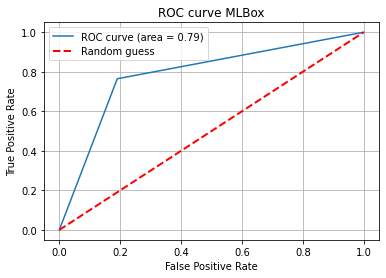

In [ ]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC curve MLBox')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

# Test dataset

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# A dense numpy array of the sparse matrix outputted can be made by using:
# X_train.toarray()
def create_test_data(num, process):  
  test_df = pd.read_csv("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/NPS_TestContent.csv", encoding='utf8', engine='c')
  
  # 2 null rows were found so drop them
  print("2 sum: ", test_df.isnull().sum().sum())
  print("1 sum: ", test_df.isnull().sum())
  test_df = test_df.dropna()
  print("2 sum: ", test_df.isnull().sum().sum())
  print("1 sum: ", test_df.isnull().sum())
  print(test_df.head())

  # the next step is to randomize the rows of the data
  test_df = test_df.sample(frac=1).reset_index(drop=True)

  # Old mapping seems to change them to floats
  test_df['sentiment'] = test_df['sentiment'].map({'Negative' : 0, 'Positive' : 1})

  # features = test_df.test.values[0:num]
  # labels = test_df.sentiment.values[0:num]
  
  features = test_df.test.values
  labels = test_df.sentiment.values
  # print(test_df.head())

  # This cell has the sk learn functions
  # Allows you to choose which function you want to use
  if process == 0:
    ctv = CountVectorizer(tokenizer=word_tokenize, token_pattern=None)

    ctv.fit(features)

    feature_vector_sparse = ctv.transform(features)

  else:
    tfv = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None)

    tfv.fit(features)

    feature_vector_sparse = tfv.transform(features)

  feature_vector = feature_vector_sparse.toarray()

  return feature_vector, labels

In [ ]:
feature_vector, labels = create_test_data(500, 1)

h2o_features_test = h2o.H2OFrame(feature_vector)

h2o_labels_test = h2o.H2OFrame(labels, column_names=["labels"])

2 sum:  2
1 sum:  test         0
sentiment    2
dtype: int64
2 sum:  0
1 sum:  test         0
sentiment    0
dtype: int64
                                   test sentiment
0                  Normal use is light.  Positive
1                      I use it myself.  Positive
2            There's no way to compare.  Positive
3     Each person has his or her taste.  Positive
4  I think there's a sense of security.  Positive
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [ ]:
h2o_features_test.head()

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100,C101,C102,C103,C104,C105,C106,C107,C108,C109,C110,C111,C112,C113,C114,C115,C116,C117,C118,C119,C120,C121,C122,C123,C124,C125,C126,C127,C128,C129,C130,C131,C132,C133,C134,C135,C136,C137,C138,C139,C140,C141,C142,C143,C144,C145,C146,C147,C148,C149,C150,C151,C152,C153,C154,C155,C156,C157,C158,C159,C160,C161,C162,C163,C164,C165,C166,C167,C168,C169,C170,C171,C172,C173,C174,C175,C176,C177,C178,C179,C180,C181,C182,C183,C184,C185,C186,C187,C188,C189,C190,C191,C192,C193,C194,C195,C196,C197,C198,C199,C200
0,0,0,0,0,0,0,0,0,0,0.12789,0,0,0,0,0,0,0.199492,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.196493,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.235291,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.170877,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.120041,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0963225,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.162736,0,0,0,0.129484,0,0,0,0,0,0,0,0.254162,0,0.166482,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0.207687,0,0,0,0,0,0,0.215976,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.298365,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.152897,0,0,0.11351,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
h2o_labels_test.head()

labels
1
1
0
0
0
1
0
1
1
1


In [ ]:
imported_model = h2o.import_mojo("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/ExportedModels/H2O/DRF_1_AutoML_20210329_152010.zip")

generic Model Build progress: |███████████████████████████████████████████| 100%
Model Details
H2OGenericEstimator :  Import MOJO Model
Model Key:  Generic_model_python_1617039431370_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,35.0,35.0,14534.0,7.0,19.0,12.142858,24.0,33.0,27.885714




ModelMetricsRegressionGeneric: generic
** Reported on train data. **

MSE: 0.2124097052862041
RMSE: 0.4608792740905194
MAE: 0.4049529638575696
RMSLE: 0.32505282783000067
Mean Residual Deviance: 0.2124097052862041

ModelMetricsRegressionGeneric: generic
** Reported on validation data. **

MSE: 0.193265306122449
RMSE: 0.4396195015265462
MAE: 0.3966165413533835
RMSLE: 0.3066713266186295
Mean Residual Deviance: 0.193265306122449

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2021-03-29 15:24:49,0.727 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2021-03-29 15:25:08,20.466 sec,5.0,0.587635,0.426643,0.345315,0.465663,0.384211,0.216842
2,,2021-03-29 15:25:23,34.596 sec,10.0,0.542543,0.427624,0.294353,0.439048,0.377632,0.192763
3,,2021-03-29 15:25:37,49.070 sec,15.0,0.515118,0.427102,0.265346,0.436761,0.389474,0.190760
4,,2021-03-29 15:25:51,1 min 3.425 sec,20.0,0.493293,0.419845,0.243338,0.435550,0.388816,0.189704
5,,2021-03-29 15:26:05,1 min 17.237 sec,25.0,0.481017,0.412713,0.231377,0.431521,0.384737,0.186211
6,,2021-03-29 15:26:19,1 min 31.458 sec,30.0,0.471068,0.409232,0.221905,0.438248,0.393421,0.192061
7,,2021-03-29 15:26:33,1 min 45.142 sec,35.0,0.460879,0.404953,0.212410,0.439620,0.396617,0.193265



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,C1324,155.015259,1.000000,0.085535
1,C4525,44.435265,0.286651,0.024519
2,C478,41.216396,0.265886,0.022742
3,C13312,39.643764,0.255741,0.021875
4,C2361,38.905914,0.250981,0.021468
5,C13616,26.565105,0.171371,0.014658
6,C7,26.116829,0.168479,0.014411
7,C183,23.547245,0.151903,0.012993
8,C12973,22.093805,0.142527,0.012191
9,C6218,21.175039,0.136600,0.011684



See the whole table with table.as_data_frame()



In [ ]:
h2o_features_test.cor()

C1 C2 C3 C4 C5 C6 C7 C8 C9 C10 C11 C12 C13 C14 C15 C16 C17 C18 C19 C20 C21 C22 C23 C24 C25 C26 C27 C28 C29 C30 C31 C32 C33 C34 C35 C36 C37 C38 C39 C40 C41 C42 C43 C44 C45 C46 C47 C48 C49 C50 C51 C52 C53 C54 C55 C56 C57 C58 C59 C60 C61 C62 C63 C64 C65 C66 C67 C68 C69 C70 C71 C72 C73 C74 C75 C76 C77 C78 C79 C80 C81 C82 C83 C84 C85 C86 C87 C88 C89 C90 C91 C92 C93 C94 C95 C96 C97 C98 C99 C100 C101 C102 C103 C104 C105 C106 C107 C108 C109 C110 C111 C112 C113 C114 C115 C116 C117 C118 C119 C120 C121 C122 C123 C124 C125 C126 C127 C128 C129 C130 C131 C132 C133 C134 C135 C136 C137 C138 C139 C140 C141 C142 C143 C144 C145 C146 C147 C148 C149 C150 C151 C152 C153 C154 C155 C156 C157 C158 C159 C160 C161 C162 C163 C164 C165 C166 C167 C168 C169 C170 C171 C172 C173 C174 C175 C176 C177 C178 C179 C180 C181 C182 C183 C184 C185 C186 C187 C188 C189 C190 C191 C192 C193 C194 C195 C196 C197 C198 C199 C200 C201 C202 C203 C204 C205 C206 C207 C208 C209 C210 C211 C212 C213 C214 C215 C216 C217 C218 C219 C220 C221 C222 C223 C224 C225 C226 C227 C228 C229 C230 C231 C232 C233 C234 C235 C236 C237 C238 C239 C240 C241 C242 C243 C244 C245 C246 C247 C248 C249 C250 C251 C252 C253 C254 C255 C256 C257 C258 C259 C260 C261 C262 C263 C264 C265 C266 C267 C268 C269 C270 C271 C272 C273 C274 C275 C276 C277 C278 C279 C280 C281 C282 C283 C284 C285 C286 C287 C288 C289 C290 C291 C292 C293 C294 C295 C296 C297 C298 C299 C300 C301 C302 C303 C304 C305 C306 C307 C308 C309 C310 C311 C312 C313 C314 C315 C316 C317 C318 C319 C320 C321 C322 C323 C324 C325 C326 C327 C328 C329 C330 C331 C332 C333 C334 C335 C336 C337 C338 C339 C340 C341 C342 C343 C344 C345 C346 C347 C348 C349 C350 C351 C352 C353 C354 C355 C356 C357 C358 C359 C360 C361 C362 C363 C364 C365 C366 C367 C368 C369 C370 C371 C372 C373 C374 C375 C376 C377 C378 C379 C380 C381 C382 C383 C384 C385 C386 C387 C388 C389 C390 C391 C392 C393 C394 C395 C396 C397 C398 C399 C400 C401 C402 C403 C404 C405 C406 C407 C408 C409 C410 C411 C412 C413 C414 C415 C416 C417 C418 C419 C420 C421 C422 C423 C424 C425 C426 C427 C428 C429 C430 C431 C432 C433 C434 C435 C436 C437 C438 C439 C440 C441 C442 C443 C444 C445 C446 C447 C448 C449 C450 C451 C452 C453 C454 C455 C456 C457 C458 C459 C460 C461 C462 C463 C464 C465 C466 C467 C468 C469 C470 C471 C472 C473 C474 C475 C476 C477 C478 C479 C480 C481 C482 C483 C484 C485 C486 C487 C488 C489 C490 C491 C492 C493 C494 C495 C496 C497 C498 C499 C500 C501 C502 C503 C504 C505 C506 C507 C508 C509 C510 C511 C512 C513 C514 C515 C516 C517 C518 C519 C520 C521 C522 C523 C524 C525 C526 C527 C528 C529 C530 C531 C532 C533 C534 C535 C536 C537 C538 C539 C540 C541 C542 C543 C544 C545 C546 C547 C548 C549 C550 C551 C552 C553 C554 C555 C556 C557 C558 C559 C560 C561 C562 C563 C564 C565 C566 C567 C568 C569 C570 C571 C572 C573 C574 C575 C576 C577 C578 C579 C580 C581 C582 C583 C584 C585 C586 C587 C588 C589 C590 C591 C592 C593 C594 C595 C596 C597 C598 C599 C600 C601 C602 C603 C604 C605 C606 C607 C608 C609 C610 C611 C612 C613 C614 C615 C616 C617 C618 C619 C620 C621 C622 C623 C624 C625 C626 C627 C628 C629 C630 C631 C632 C633 C634 C635 C636 C637 C638 C639 C640 C641 C642 C643 C644 C645 C646 C647 C648 C649 C650 C651 C652 C653 C654 C655 C656 C657 C658 C659 C660 C661 C662 C663 C664 C665 C666 C667 C668 C669 C670 C671 C672 C673 C674 C675 C676 C677 C678 C679 C680 C681 C682 C683 C684 C685 C686 C687 C688 C689 C690 C691 C692 C693 C694 C695 C696 C697 C698 C699 C700 C701 C702 C703 C704 C705 C706 C707 C708 C709 C710 C711 C712 C713 C714 C715 C716 C717 C718 C719 C720 C721 C722 C723 C724 C725 C726 C727 C728 C729 C730 C731 C732 C733 C734 C735 C736 C737 C738 C739 C740 C741 C742 C743 C744 C745 C746 C747 C748 C749 C750 C751 C752 C753 C754 C755 C756 C757 C758 C759 C760 C761 C762 C763 C764 C765 C766 C767 C768 C769 C770 C771 C772 C773 C774 C775 C776 C777 C778 C779 C780 C781 C782 C783 C784 C785 C786 C787 C788 C789 C790 C791 C792 C793 C794 C795 C796 C797 C798 C799 C800 C801 C802 C803 C804 C805 C806 C807 C808 C809 C810 C811 C812 C813 C814 C815 C816 C817 C818 C819 C820 C821 C82

In [ ]:
h2o_features_test.isna()

isNA(C1) isNA(C2) isNA(C3) isNA(C4) isNA(C5) isNA(C6) isNA(C7) isNA(C8) isNA(C9) isNA(C10) isNA(C11) isNA(C12) isNA(C13) isNA(C14) isNA(C15) isNA(C16) isNA(C17) isNA(C18) isNA(C19) isNA(C20) isNA(C21) isNA(C22) isNA(C23) isNA(C24) isNA(C25) isNA(C26) isNA(C27) isNA(C28) isNA(C29) isNA(C30) isNA(C31) isNA(C32) isNA(C33) isNA(C34) isNA(C35) isNA(C36) isNA(C37) isNA(C38) isNA(C39) isNA(C40) isNA(C41) isNA(C42) isNA(C43) isNA(C44) isNA(C45) isNA(C46) isNA(C47) isNA(C48) isNA(C49) isNA(C50) isNA(C51) isNA(C52) isNA(C53) isNA(C54) isNA(C55) isNA(C56) isNA(C57) isNA(C58) isNA(C59) isNA(C60) isNA(C61) isNA(C62) isNA(C63) isNA(C64) isNA(C65) isNA(C66) isNA(C67) isNA(C68) isNA(C69) isNA(C70) isNA(C71) isNA(C72) isNA(C73) isNA(C74) isNA(C75) isNA(C76) isNA(C77) isNA(C78) isNA(C79) isNA(C80) isNA(C81) isNA(C82) isNA(C83) isNA(C84) isNA(C85) isNA(C86) isNA(C87) isNA(C88) isNA(C89) isNA(C90) isNA(C91) isNA(C92) isNA(C93) isNA(C94) isNA(C95) isNA(C96) isNA(C97) isNA(C98) isNA(C99) isNA(C100) isNA(C101) isNA(C102) isNA(C103) isNA(C104) isNA(C105) isNA(C106) isNA(C107) isNA(C108) isNA(C109) isNA(C110) isNA(C111) isNA(C112) isNA(C113) isNA(C114) isNA(C115) isNA(C116) isNA(C117) isNA(C118) isNA(C119) isNA(C120) isNA(C121) isNA(C122) isNA(C123) isNA(C124) isNA(C125) isNA(C126) isNA(C127) isNA(C128) isNA(C129) isNA(C130) isNA(C131) isNA(C132) isNA(C133) isNA(C134) isNA(C135) isNA(C136) isNA(C137) isNA(C138) isNA(C139) isNA(C140) isNA(C141) isNA(C142) isNA(C143) isNA(C144) isNA(C145) isNA(C146) isNA(C147) isNA(C148) isNA(C149) isNA(C150) isNA(C151) isNA(C152) isNA(C153) isNA(C154) isNA(C155) isNA(C156) isNA(C157) isNA(C158) isNA(C159) isNA(C160) isNA(C161) isNA(C162) isNA(C163) isNA(C164) isNA(C165) isNA(C166) isNA(C167) isNA(C168) isNA(C169) isNA(C170) isNA(C171) isNA(C172) isNA(C173) isNA(C174) isNA(C175) isNA(C176) isNA(C177) isNA(C178) isNA(C179) isNA(C180) isNA(C181) isNA(C182) isNA(C183) isNA(C184) isNA(C185) isNA(C186) isNA(C187) isNA(C188) isNA(C189) isNA(C190) isNA(C191) isNA(C192) isNA(C193) isNA(C194) isNA(C195) isNA(C196) isNA(C197) isNA(C198) isNA(C199) isNA(C200) isNA(C201) isNA(C202) isNA(C203) isNA(C204) isNA(C205) isNA(C206) isNA(C207) isNA(C208) isNA(C209) isNA(C210) isNA(C211) isNA(C212) isNA(C213) isNA(C214) isNA(C215) isNA(C216) isNA(C217) isNA(C218) isNA(C219) isNA(C220) isNA(C221) isNA(C222) isNA(C223) isNA(C224) isNA(C225) isNA(C226) isNA(C227) isNA(C228) isNA(C229) isNA(C230) isNA(C231) isNA(C232) isNA(C233) isNA(C234) isNA(C235) isNA(C236) isNA(C237) isNA(C238) isNA(C239) isNA(C240) isNA(C241) isNA(C242) isNA(C243) isNA(C244) isNA(C245) isNA(C246) isNA(C247) isNA(C248) isNA(C249) isNA(C250) isNA(C251) isNA(C252) isNA(C253) isNA(C254) isNA(C255) isNA(C256) isNA(C257) isNA(C258) isNA(C259) isNA(C260) isNA(C261) isNA(C262) isNA(C263) isNA(C264) isNA(C265) isNA(C266) isNA(C267) isNA(C268) isNA(C269) isNA(C270) isNA(C271) isNA(C272) isNA(C273) isNA(C274) isNA(C275) isNA(C276) isNA(C277) isNA(C278) isNA(C279) isNA(C280) isNA(C281) isNA(C282) isNA(C283) isNA(C284) isNA(C285) isNA(C286) isNA(C287) isNA(C288) isNA(C289) isNA(C290) isNA(C291) isNA(C292) isNA(C293) isNA(C294) isNA(C295) isNA(C296) isNA(C297) isNA(C298) isNA(C299) isNA(C300) isNA(C301) isNA(C302) isNA(C303) isNA(C304) isNA(C305) isNA(C306) isNA(C307) isNA(C308) isNA(C309) isNA(C310) isNA(C311) isNA(C312) isNA(C313) isNA(C314) isNA(C315) isNA(C316) isNA(C317) isNA(C318) isNA(C319) isNA(C320) isNA(C321) isNA(C322) isNA(C323) isNA(C324) isNA(C325) isNA(C326) isNA(C327) isNA(C328) isNA(C329) isNA(C330) isNA(C331) isNA(C332) isNA(C333) isNA(C334) isNA(C335) isNA(C336) isNA(C337) isNA(C338) isNA(C339) isNA(C340) isNA(C341) isNA(C342) isNA(C343) isNA(C344) isNA(C345) isNA(C346) isNA(C347) isNA(C348) isNA(C349) isNA(C350) isNA(C351) isNA(C352) isNA(C353) isNA(C354) isNA(C355) isNA(C356) isNA(C357) isNA(C358) isNA(C359) isNA(C360) isNA(C361) isNA(C362) isNA(C363) isNA(C364) isNA(C365) isNA(C366) isNA(C367) isNA(C368) isNA(C369) isNA(C370) isNA(C371) isNA(C372) isNA(C373) isNA(

In [ ]:
# Old
# imported_model = h2o.import_mojo("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/ExportedModels/H2O/GBM_1_AutoML_20210329_093118.zip")
# Current
imported_model = h2o.import_mojo("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/ExportedModels/H2O/DRF_1_AutoML_20210329_152010.zip")
# Using the best model make predictions
predictions = imported_model.predict(h2o_features_test)
# First 10 predictions
predictions.head()

---

---

---

---

# Old Code Section

---

---

---

---

---


In [ ]:
# Create the set of stopwords for cleaning text
stopwords = set(w.rstrip() for w in open('/content/drive/MyDrive/CIT/FYP/ImplementationFiles/stopwords.txt'))

In [ ]:
# This funciton handles celaning text
def clean_text(text):
    # Create the lemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    
    # Get rid of non alpha characters except "'" as it is needed for the lemment
    text = "".join(c for c in text if c.isalnum() or c == " " or "'")
    
    # Get rid of capitals
    text = text.lower()
    
    # Tokenize the words    
    # Create tokens of each word
    token_text = word_tokenize(text)
    
    # Get rid of any piece of text that isn't over 2 characters
    token_text = [t for t in token_text if len(t) > 2] 
    
    # Put words in base form by doing lemmatization
    token_text = [wordnet_lemmatizer.lemmatize(t) for t in token_text]

    # Remove stopwords
    token_text = [t for t in token_text if t not in stopwords]
    
    # Return the tokens
    return token_text

In [ ]:
# This function will get the term frequencies for word in the review
# TF = Term I frequency in document/total words in document
def calc_tf(term_count, review_corpus):
    # A dictionary of all the term frequencies found
    tf_freq = dict.fromkeys(term_count.keys(), 0)   
    
    # Review corpus is a tokenized list so the total words iteh length
    total_words = len(review_corpus)
    
    # Calculate the term frequency for each word
    for word, count in term_count.items():
        tf_freq[word] = count/total_words
        
    return tf_freq

In [ ]:
# This calcualtes the idf
# IDF = log(2)*(Total number of Documents/documents frequency or documents with term)
def calc_idf(unique_terms, list_doc_terms):   
    # A dicitonary of all the inverse document frequencies
    idf = dict.fromkeys(unique_terms, 0)
    
    # Basically list_doc_terms has all the documents with the term count for each word
    # You go through each document count the terms where they occured
    for doc_terms in list_doc_terms:  
        # This for loop is counting the amount of document a word was in
        for word, value in doc_terms.items():
            if 0 < value:
                idf[word] += 1
        
    # Now we calculate idf
    for word, value in idf.items():
        idf[word] = math.log10(10 / float(value))
    
    return idf

In [ ]:
# Modified this function to return a list as dictionaries arn't needed anymore
def calc_tf_idf(tf, idf, n_terms):
    # Create an array that is of length of the number of unique terms
    tf_idf_array = np.zeros(n_terms)
    
    for index, (word, value) in enumerate(tf.items()):
        # Add the tfidf to the array
        tf_idf_array[index] = value*idf[word]
    
    return tf_idf_array

In [ ]:
def process_text(text_data):
    # A list of all the cleaned reviews
    doc_list = []
    
    # List of all the unique terms
    unique_terms = []
    
    # A list of all the term frequencies
    tf_list = []
    
    for review in text_data:
        # First clean the review
        clean_review = clean_text(review)
        
        # Keeps track of the term counts for each word
        count_dict = {}
        
        # Now lets find the total count for each word
        for token in clean_review:
            if token not in count_dict:
                count_dict[token] = 1
            else:
                count_dict[token] += 1
        
        # Caclulate the term frequencies for each document
        tf_list.append(calc_tf(count_dict, clean_review))
        
        # Then add the dictionary of counts for each document to the list
        doc_list.append(count_dict)
        
        # Then add the new unique terms
        unique_terms = set(unique_terms).union(set(clean_review))
    
    # Calculate the inverse document frequency value
    idf = calc_idf(unique_terms, doc_list)
    
    # This array will contain the tfidf values for each term in each review
    tfidf_values = np.zeros((len(tf_list), len(unique_terms)))
    
    # Now we can get the TFIDF for each document
    for index, term_freq in enumerate(tf_list):
        # This will return an array of the tfidf values calculated.
        # The length of the unique terms list is passed in so that the 
        # Array that is returned matches the tfidf array
        tf_idf_array = calc_tf_idf(term_freq, idf, len(unique_terms))
        # Add this to the overall tfidf values calculated
        tfidf_values[index,:] = tf_idf_array
    
    return tfidf_values

In [ ]:
# Prepare the data
def prepare_data(num):
    print("="*50)

    # Load the dataset
    # imdb_df = pd.read_csv("IMDB Dataset.csv")
    imdb_df = pd.read_csv("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/IMDB_Dataset.csv")
    print("Dataset loaded")
    print("="*50)

    
     # Change each positive and negative value to 1 and 0 respectively    
    # imdb_df['sentiment'] = imdb_df['sentiment'].map({'negative' : 0, 'positive' : 1})
    
    # For testing, a much smaller dataset is going to be used
    # imdb_df = imdb_df.head(25000)

    # Group all the negative reviews and get the first 2500
    # imdb_df_neg = (imdb_df[imdb_df['sentiment'] == 0])[0:num]
    imdb_df_neg = (imdb_df[imdb_df['sentiment'] == "negative"])[0:num]
    
    # Group all the positive and get the first 2500
    # imdb_df_pos = imdb_df[imdb_df['sentiment'] == 1][0:num]
    imdb_df_pos = imdb_df[imdb_df['sentiment'] == "positive"][0:num]
    
    # Combine the two split positives and negatives into one dataframe
    imdb_df = pd.concat([imdb_df_neg, imdb_df_pos]) 
    # print(test_df)
    
    # .values on a column of a dataframe returns a numpy array
    # This is a numpy array of all the reviews
    # initial_reviews = imdb_df['review'].values
    initial_reviews = imdb_df['review'].values
    
    # This is a numpy array of all the positive and negativelabels
    # labels = imdb_df['sentiment'].values
    labels = imdb_df['sentiment'].values
    
    print("Creating Feature Vector")
    print("="*50)
    start = time.time()
    # Process the text data and create teh feature vector
    feature_vector = process_text(initial_reviews)
    end = time.time()
    print("Feature Vector Created")
    print(len(feature_vector))
    print(f"Execution time is {end - start} secs")
    print("="*50)
    
    # Shuffle the labesl and feature vector using sklearn shuffle
    feature_vector, labels = shuffle(feature_vector, labels)
    
    return feature_vector, labels

In [ ]:
# X_train, y_train, X_test, y_test = prepare_data()
# num = 100 worked
feature_vector, labels = prepare_data(500)

# Convert feature_vectors into a pandas dataframe of 
# term frequency inverse document frequency of each word
tfidf_tf = pd.DataFrame(feature_vector)

# Add the labels
tfidf_tf['labels'] = labels

#==========================================
# Insert the code for running the libraries in here
h2o_tfidf = h2o.H2OFrame(tfidf_tf)
# Set labels to be a categorical field
h2o_tfidf['labels'] = h2o_tfidf['labels'].asfactor()
# print(h2o_tfidf.head())

In [ ]:
# from h20_tfidf_pred, get the positive column where the predict column = positive
positive_values = h2o_tfidf_pred[h2o_tfidf_pred["predict"] == "positive"]["positive"]
negative_values = h2o_tfidf_pred[h2o_tfidf_pred["predict"] == "negative"]["negative"]

# Seperate the values into seperate strings
positive_values = positive_values.get_frame_data().split("\n")
negative_values = negative_values.get_frame_data().split("\n")

# Remove the initial column heading
positive_values.pop(0)
negative_values.pop(0)

# Remove the empy string at the end
positive_values.pop(-1)
negative_values.pop(-1)

# Convert the string values in the list to float
positive_values = [float(i) for i in positive_values]
negative_values = [float(i) for i in positive_values]
# print(positive_values)

In [ ]:
y_pred = []

# Get all the individual vales as a list of strings from the predict column
predict_list = h2o_tfidf_pred["predict"].get_frame_data().split("\n")
predict_list.pop(0)
predict_list.pop(-1)

positive_list = h2o_tfidf_pred["positive"].get_frame_data().split("\n")
positive_list.pop(0)
positive_list.pop(-1)

negative_list = h2o_tfidf_pred["negative"].get_frame_data().split("\n")
negative_list.pop(0)
negative_list.pop(-1)

for predict in predict_list:
  # print(predict)
  if predict == "\"positive\"":
    y_pred.append(1)
  else:
    y_pred.append(0)

# Convert the string vlaues to floats and in a numpy array format
# y_pred = np.array([float(i) for i in y_pred])
# y_pred = [float(i) for i in y_pred]
print(len(y_pred))
print(y_pred[0:100])

In [ ]:
# Map the positive and neagtives to 0 and 1
y_test = h2o_tfidf_test['labels'].asnumeric()

y_test = y_test["labels"].get_frame_data().split("\n")
y_test.pop(0)
y_test.pop(-1)

# Convert to int
# y_test = np.array([int(i) for i in y_test])
y_test = [int(i) for i in y_test]

print(y_test)

In [ ]:
from sklearn.metrics import accuracy_score
testing_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy score {0}".format(testing_accuracy))

# Manual Metrics

In [ ]:
from sklearn import metrics

# paramters are y_true, y_pred
C = metrics.confusion_matrix(y_test, y_pred)

# lists for the confusion matrix
true_positive = []
true_negative = []
false_postiive = []
false_negatives = []

true_positive.append(C[0,0])
true_negative.append(C[1,1])            
false_postiive.append(C[1,0])
false_negatives.append(C[0,1])

print(C)

print(("="*50))

print("True positives:", round(np.sum(true_positive)/len(y_test), 5), "%")
print("True negatives:", round(np.sum(true_negative)/len(y_test), 5), "%")
print("False positives:", round(np.sum(false_postiive)/len(y_test), 5), "%")
print("False negatives:", round(np.sum(false_negatives)/len(y_test), 5), "%")

In [ ]:
true_positive = C[0,0]
true_negative = C[1,1]            
false_postiive = C[1,0]
false_negatives = C[0,1]

precision = true_positive/(true_positive+false_postiive)
recall = true_positive/(true_positive/false_negatives)

In [ ]:
f1_score = (precision*recall)/(precision+recall)

print(f1_score)

In [ ]:
fpr, tpr, thresh = metrics.roc_curve(y_test, y_pred)

auc = metrics.auc(fpr, tpr)

print("AUC:", auc)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC curve MLBox')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# This is a performance report
h2o_model.leader.model_performance(h2o_tfidf_test)

# Get the best model and run inbuilt metrics on it

In [ ]:
h2o_model.leader.predict(h2o_tfidf_test)
lb.head()

gbm prediction progress: |████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GBM_2_AutoML_20210329_171419,0.160405,0.400505,0.160405,0.358903,0.277266
DRF_1_AutoML_20210329_171419,0.173691,0.416762,0.173691,0.389388,0.290184
XGBoost_2_AutoML_20210329_171419,0.183116,0.42792,0.183116,0.364869,0.304055
GBM_4_AutoML_20210329_171419,0.203043,0.450602,0.203043,0.399302,0.305971
GBM_1_AutoML_20210329_171419,0.20397,0.45163,0.20397,0.396527,0.306229
GBM_3_AutoML_20210329_171419,0.20509,0.452868,0.20509,0.39135,0.304245
GLM_1_AutoML_20210329_171419,0.213289,0.461832,0.213289,0.452464,0.325898
XGBoost_3_AutoML_20210329_171419,0.235544,0.485329,0.235544,0.41497,0.334675
GBM_5_AutoML_20210329_171419,0.237564,0.487406,0.237564,0.478736,0.342504
XGBoost_1_AutoML_20210329_171419,0.328159,0.572852,0.328159,0.475041,0.405584


In [ ]:
# best_model = h2o.get_model(h2o_model.leader.model_id)
# best_model.confusion_matrix()

# print(h2o_model.leader.model_id)
# id = h2o_model.leader.model_id
# print(h2o.get_model(id))

best_model = h2o.get_model(h2o_model.leader.model_id)
# best_model

In [ ]:
print(best_model)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_2_AutoML_20210329_171419


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,30.0,30.0,7139.0,7.0,7.0,7.0,9.0,21.0,14.166667




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.041135293144357585
RMSE: 0.20281837477003306
MAE: 0.181767305756342
RMSLE: 0.1482662074168188
Mean Residual Deviance: 0.041135293144357585

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 0.2434913107499557
RMSE: 0.49344838711860806
MAE: 0.45992774127648534
RMSLE: 0.33826269940073117
Mean Residual Deviance: 0.2434913107499557

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2021-03-29 17:28:32,0.517 sec,0.0,0.498152,0.496311,0.248156,0.505602,0.503789,0.255634
1,,2021-03-29 17:28:52,19.878 sec,5.0,0.410824,0.404172,0.168776,0.506694,0.498555,0.256739
2,,2021-03-29 17:29:07,35.838 sec,10.0,0.345759,0.335193,0.119549,0.493801,0.476067,0.243840
3,,2021-03-29 17:29:21,49.038 sec,15.0,0.295159,0.281434,0.087119,0.494318,0.472833,0.244350
4,,2021-03-29 17:29:37,1 min 5.620 sec,20.0,0.257600,0.240367,0.066358,0.494735,0.468856,0.244763
5,,2021-03-29 17:29:54,1 min 22.429 sec,25.0,0.224946,0.204713,0.050601,0.491170,0.460779,0.241248
6,,2021-03-29 17:30:11,1 min 39.126 sec,30.0,0.202818,0.181767,0.041135,0.493448,0.459928,0.243491



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,C1311,22.066494,1.000000,0.061161
1,C8321,14.677626,0.665154,0.040682
2,C8140,13.268517,0.601297,0.036776
3,C13463,12.236698,0.554537,0.033916
4,C6573,10.890035,0.493510,0.030184
5,C2058,10.190705,0.461818,0.028245
6,C6589,9.376299,0.424911,0.025988
7,C786,7.769815,0.352109,0.021535
8,C12351,7.399463,0.335326,0.020509
9,C5734,7.330398,0.332196,0.020317



See the whole table with table.as_data_frame()



In [ ]:
best_model.F1()

AttributeError: ignored

In [ ]:
best_model.accuracy()

In [ ]:
best_model.auc()

In [ ]:
best_model.predict(h2o_tfidf_test)

In [ ]:
# This outputs the model as a mojo file which is meant to be a binary object 
# that can work in other languages
h2o_model.leader.download_mojo(path = "/content/drive/MyDrive/CIT/FYP/ImplementationFiles/ExportedModels/H2O")

In [ ]:
# Old
# imported_model = h2o.import_mojo("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/ExportedModels/H2O/GBM_1_AutoML_20210329_093118.zip")
# Current
imported_model = h2o.import_mojo("/content/drive/MyDrive/CIT/FYP/ImplementationFiles/ExportedModels/H2O/DRF_1_AutoML_20210329_152010.zip")
# Using the best model make predictions
predictions = imported_model.predict(h2o_tfidf_test)
# First 10 predictions
predictions.head()